# Test plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import get_correspondences, extract_corresponding_features
from planeslam.geometry.util import quat_to_rot_mat

%load_ext autoreload
%autoreload 2

### Test with two planes

In [2]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t_gt = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
R_gt = expmap(theta*u.flatten())

print("t_gt: ", t_gt)
print("R_gt: ", R_gt)

Q = copy.deepcopy(P)
Q.transform(R_gt, t_gt.flatten())

vertex and face generation not yet implemented
t_gt:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R_gt:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


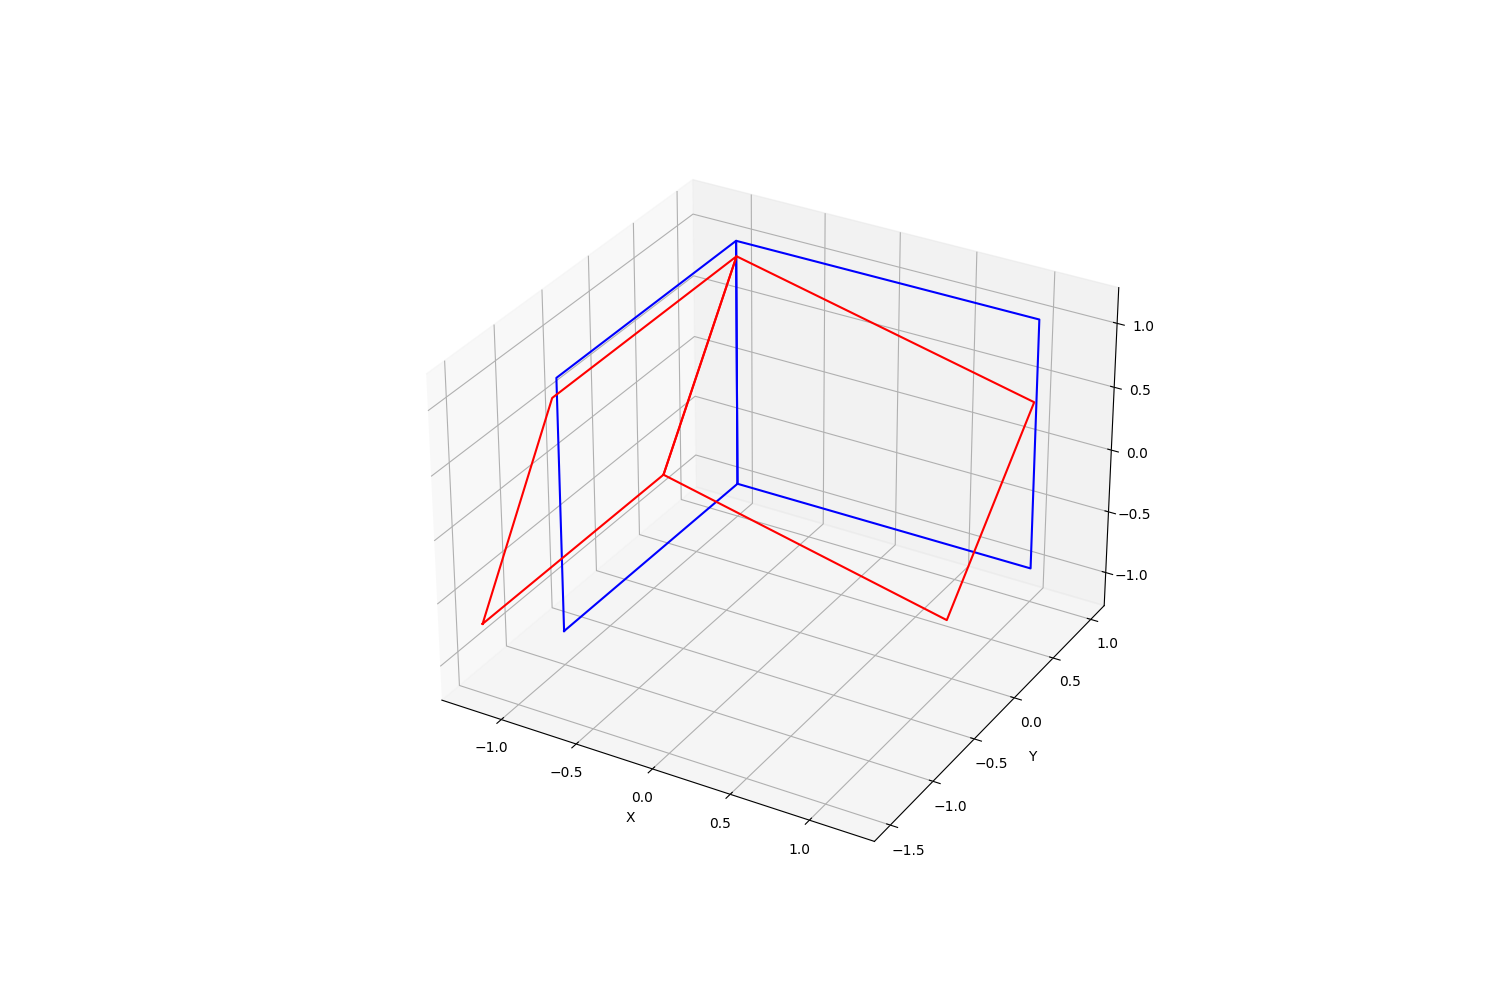

In [3]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [4]:
# P is source, Q is target
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

PyTorch3D optimization

In [5]:
# imports
import torch
from pytorch3d.transforms.so3 import (
    so3_exp_map
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [6]:
# Convert features to torch tensors
n_s = torch.from_numpy(n_s).float().to(device)
d_s = torch.from_numpy(d_s).float().to(device)
n_t = torch.from_numpy(n_t).float().to(device)
d_t = torch.from_numpy(d_t).float().to(device)

In [7]:
def residual(q, n_s, d_s, n_t, d_t):
    """Residual used to define loss to optimize

    Parameters
    ----------
    log_R : torch.tensor (1 x 3)
        Current parameterized rotation estimate
    t : torch.tensor (3 x 1)
    n_s : np.array (3N x 1)
        Stacked vector of source normals
    d_s : np.array (N x 1)
        Stacked vector of source distances
    n_t : np.array (3N x 1)
        Stacked vector of target normals
    d_t : np.array (N x 1)
        Stacked vector of target distances

    Returns
    -------
    r : np.array (4N x 1)
        Stacked vector of plane-to-plane error residuals
    
    """
    assert len(n_s) % 3 == 0, "Invalid normals vector, length should be multiple of 3"
    N = int(len(n_s) / 3)

    t = q[:3]
    log_R = q[3:].T

    R = so3_exp_map(log_R)
    n_q = (R @ n_s.reshape((N, 3)).T).T.reshape((3*N, 1))

    d_q = d_s + n_q.reshape((-1,3)) @ t 

    r = torch.vstack((n_q - n_t, d_q - d_t))
    return r

In [8]:
# Initial transformation
q_init = torch.randn(6, 1, dtype=torch.float32, device=device)

# Instantiate copy of the initialization 
q = q_init.clone().detach()
q.requires_grad = True

init_R = so3_exp_map(q[3:].T)
print(f'Init: R = {init_R} \n t = {q[:3]}')

# Init the optimizer
optimizer = torch.optim.SGD([q], lr=0.1, momentum=0.9)

# Run the optimization
n_iter = 100  # fix the number of iterations
start_time = time.time()
for it in range(n_iter):
    # Re-init the optimizer gradients
    optimizer.zero_grad()

    # Compute loss
    r = residual(q, n_s, d_s, n_t, d_t)
    loss = torch.linalg.norm(r)**2

    loss.backward(retain_graph=True)
    
    # Apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 10==0 or it==n_iter-1:
        print(f'Iteration: {it}, loss: {loss}')

print(f'Optimization finished in {time.time() - start_time} seconds.')
print(f'Final: R = {so3_exp_map(q[3:].T)} \n t = {q[:3]}')

Init: R = tensor([[[ 0.6380,  0.7550,  0.1513],
         [-0.6443,  0.4158,  0.6418],
         [ 0.4217, -0.5070,  0.7518]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[-0.7223],
        [-1.1894],
        [ 0.3581]], device='cuda:0', grad_fn=<SliceBackward>)
Iteration: 0, loss: 2.8830528259277344
Iteration: 10, loss: 0.3133317530155182
Iteration: 20, loss: 0.14423011243343353
Iteration: 30, loss: 0.05588755011558533
Iteration: 40, loss: 0.024628236889839172
Iteration: 50, loss: 0.00958337914198637
Iteration: 60, loss: 0.003158080857247114
Iteration: 70, loss: 0.001043287804350257
Iteration: 80, loss: 0.00031256326474249363
Iteration: 90, loss: 0.00013387484068516642
Iteration: 99, loss: 4.762635944643989e-05
Optimization finished in 0.45596909523010254 seconds.
Final: R = tensor([[[ 0.9657, -0.0024,  0.2595],
         [ 0.0030,  1.0000, -0.0019],
         [-0.2595,  0.0026,  0.9657]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[ 0.1865],
       

In [9]:
print("t_gt: ", t_gt)
print("R_gt: ", R_gt)

t_gt:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R_gt:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


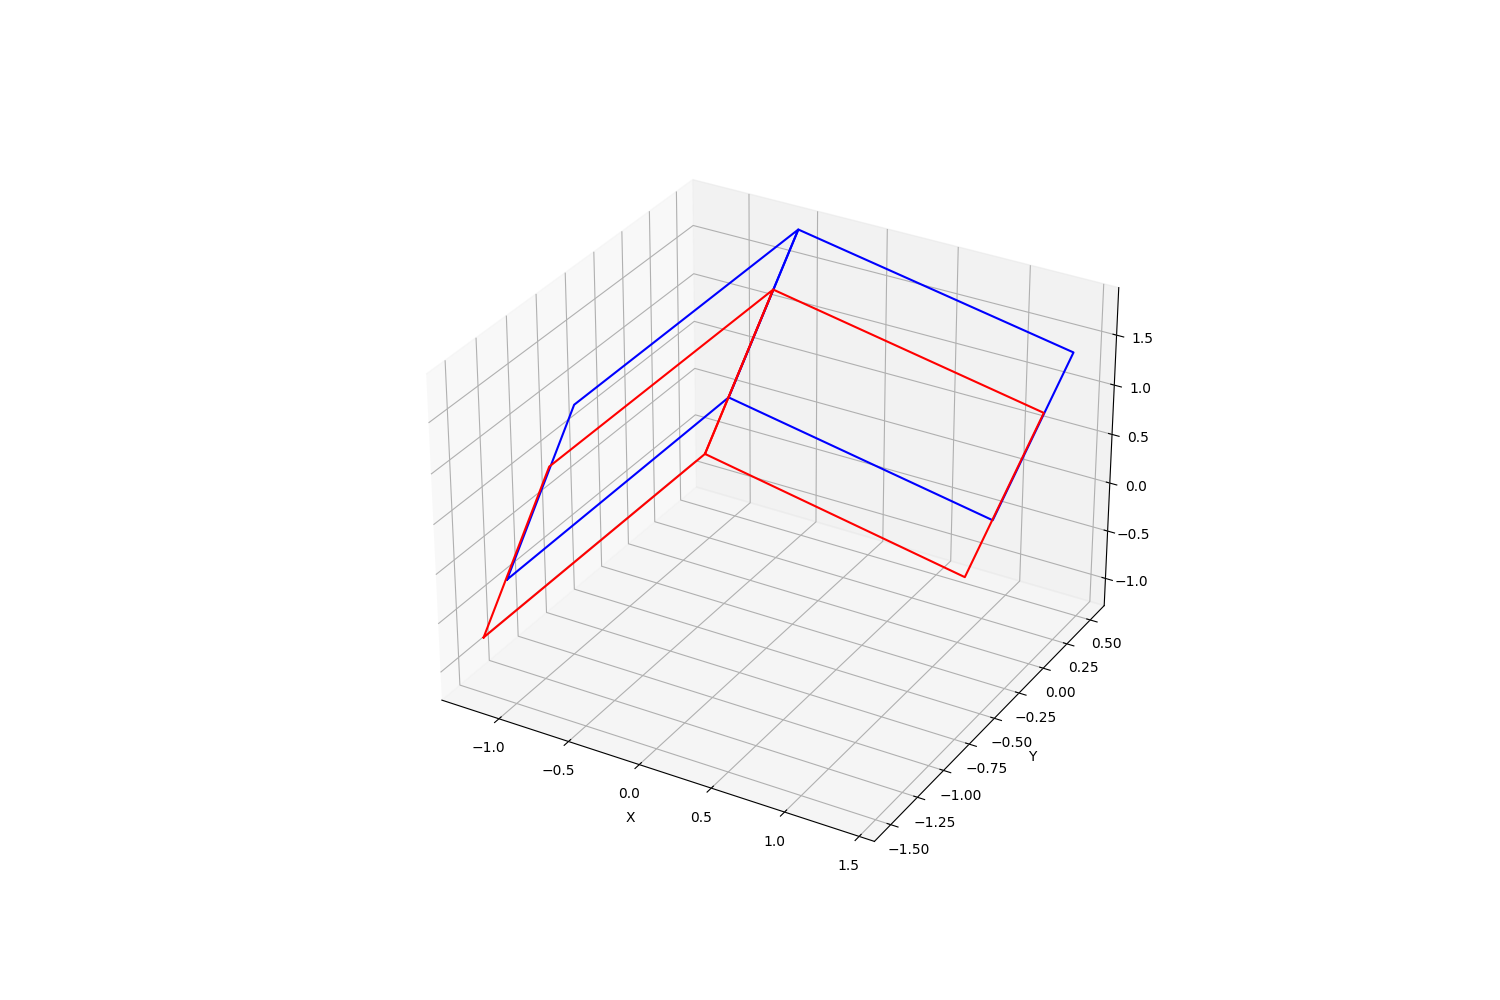

In [10]:
R_est = so3_exp_map(q[3:].T).cpu().detach().numpy()[0]
t_est = q[:3].cpu().detach().numpy()

P_t = copy.deepcopy(P)
P_t.transform(R_est, t_est.flatten())

ax = plot_3D_setup()
P_t.plot(ax, color='b')
Q.plot(ax, color='r')

### Test with Airsim data

In [11]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

In [12]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

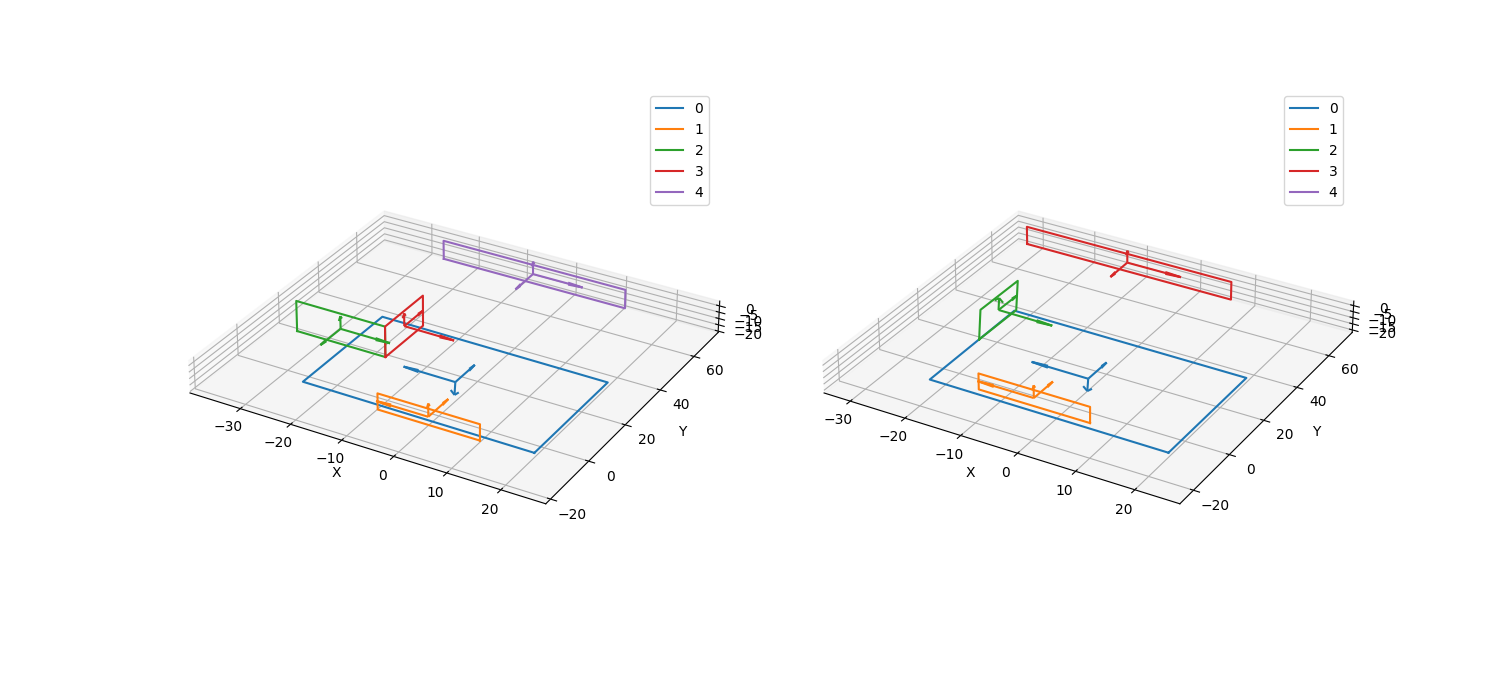

In [13]:
idx_1 = 7
idx_2 = 8

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=True)
scans[idx_2].plot(ax2, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax1, num_colors)
color_legend(ax2, num_colors)

In [14]:
# Ground-truth answer
t_gt = drone_positions[idx_2] - drone_positions[idx_1]
R_0 = quat_to_rot_mat(drone_orientations[idx_1])
R_1 = quat_to_rot_mat(drone_orientations[idx_2])
R_gt = np.linalg.inv(R_0) @ R_1

print(f't_gt: {t_gt} \n R_gt: {R_gt}')

t_gt: [4.94145775e+00 3.08169348e-08 4.38446999e-02] 
 R_gt: [[ 9.99999975e-01  4.28995207e-09  2.24396258e-04]
 [-4.28284228e-09  1.00000000e+00 -3.16845687e-08]
 [-2.24396258e-04  3.16836068e-08  9.99999975e-01]]


In [15]:
# Extract normals and distances
# Use idx_2 as source and idx_1 as target
#correspondences = get_correspondences(scans[idx_2], scans[idx_1])
correspondences = [(0,0), (1,1), (2,3), (3,4)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

In [16]:
# Convert features to torch tensors
n_s = torch.from_numpy(n_s).float().to(device)
d_s = torch.from_numpy(d_s).float().to(device)
n_t = torch.from_numpy(n_t).float().to(device)
d_t = torch.from_numpy(d_t).float().to(device)

In [26]:
so3_exp_map(torch.zeros((1,3)))

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [27]:
# Initial transformation
#q_init = torch.randn(6, 1, dtype=torch.float32, device=device)
q_init = torch.zeros(6, 1, dtype=torch.float32, device=device)

# Instantiate copy of the initialization 
q = q_init.clone().detach()
q.requires_grad = True

init_R = so3_exp_map(q[3:].T)
print(f'Init: R = {init_R} \n t = {q[:3]}')

r = residual(q, n_s, d_s, n_t, d_t)
loss = torch.linalg.norm(r)**2

# Init the optimizer
optimizer = torch.optim.SGD([q], lr=0.1, momentum=0.5)
#optimizer = torch.optim.Adam([q], lr=0.001)

# Run the optimization
n_iter = 100  # fix the number of iterations
loss_target = 1e-3  # target loss to achieve (under)
start_time = time.time()
it = 0
max_it = 250
while loss > loss_target and it < max_it:
    # Re-init the optimizer gradients
    optimizer.zero_grad()

    # Compute loss
    r = residual(q, n_s, d_s, n_t, d_t)
    loss = torch.linalg.norm(r)**2

    loss.backward(retain_graph=True)
    
    # Apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 10==0:
        print(f'Iteration: {it}, loss: {loss}')
    it += 1

print(f'Optimization finished in {time.time() - start_time} seconds.')
print(f'Final: R = {so3_exp_map(q[3:].T)} \n t = {q[:3]}')
print('Final loss: ', loss.data, ' iterations: ', it)

Init: R = tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', grad_fn=<AddBackward0>) 
 t = tensor([[0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward>)
Iteration: 0, loss: 23.67850112915039
Iteration: 10, loss: 53.308082580566406
Iteration: 20, loss: 20.974233627319336
Iteration: 30, loss: 26.30877113342285
Iteration: 40, loss: 13.85541820526123
Iteration: 50, loss: 29.03951644897461
Iteration: 60, loss: 4.038971900939941
Iteration: 70, loss: 6.941856861114502
Iteration: 80, loss: 0.5930495858192444
Iteration: 90, loss: 0.0005988976336084306
Optimization finished in 0.31319141387939453 seconds.
Final: R = tensor([[[ 1.0000e+00,  9.1834e-04,  5.3383e-04],
         [-9.2006e-04,  9.9999e-01,  3.2231e-03],
         [-5.3086e-04, -3.2235e-03,  9.9999e-01]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[ 4.8615],
        [-0.0162],
        [-0.0366]], device='cuda:0', grad_fn=<SliceBackward>)
Final loss:  tensor(

Jacobian computation

In [28]:
import torch.autograd.functional as F

q = np.array([[     4.865],
        [     0.006],
        [    -0.015],
        [    17.059],
        [     7.844],
        [     1.633]])
q = torch.from_numpy(q).float().to(device)

start_time = time.time()
J = F.jacobian(residual, (q, n_s, d_s, n_t, d_t))[0]
print(time.time() - start_time)

0.02030158042907715


In [26]:
torch.set_printoptions(precision=3, sci_mode=True)
J.reshape((16,6))

tensor([[ 0.000e+00,  0.000e+00,  0.000e+00, -3.766e-01, -1.730e-01, -3.605e-02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  8.180e-01,  3.762e-01,  7.832e-02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  3.759e-03,  1.726e-03,  3.598e-04],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -7.997e-02, -3.677e-02, -7.513e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  3.423e-03,  1.574e-03,  3.275e-04],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  8.188e-01,  3.766e-01,  7.840e-02],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -4.649e-03, -2.136e-03, -4.462e-04],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  8.983e-02,  4.131e-02,  8.457e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -3.830e-01, -1.759e-01, -3.666e-02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  7.849e-02,  3.609e-02,  7.371e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  6.583e-05,  3.026e-05,  5.956e-06],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -8.202e-01, -3.772e-01, -7.852e-02],
        [-1.460e

### Gauss Newton with PyTorch Jacobian

In [63]:
import torch.autograd.functional as F

# Randomly initialize initial estimate
q = torch.randn(6, 1, dtype=torch.float32, device=device)

# Gauss-Newton
n_iters = 10
lmbda = 1e-3
mu = 5e-1

start_time = time.time()
for i in range(n_iters):
    r = residual(q, n_s, d_s, n_t, d_t)
    print("loss: ",torch.linalg.norm(r)**2)
    # Compute Jacobian with pytorch
    J = F.jacobian(residual, (q, n_s, d_s, n_t, d_t), vectorize=True)[0].reshape((16,6))
    q = q - mu * torch.linalg.inv(J.T @ J + lmbda * torch.eye(6, device=device)) @ J.T @ r
print("elapsed time: ", time.time() - start_time)

loss:  tensor(3.019e+01, device='cuda:0')
loss:  tensor(1.094e+01, device='cuda:0')
loss:  tensor(3.281e+00, device='cuda:0')
loss:  tensor(8.434e-01, device='cuda:0')
loss:  tensor(2.077e-01, device='cuda:0')
loss:  tensor(5.144e-02, device='cuda:0')
loss:  tensor(1.296e-02, device='cuda:0')
loss:  tensor(3.395e-03, device='cuda:0')
loss:  tensor(9.977e-04, device='cuda:0')
loss:  tensor(3.948e-04, device='cuda:0')
elapsed time:  0.12317776679992676


In [59]:
print(f'Final: R = {so3_exp_map(q[3:].T)} \n t = {q[:3]}')

Final: R = tensor([[[1.000e+00, -2.799e-03, -6.027e-03],
         [2.777e-03, 1.000e+00, -3.542e-03],
         [6.037e-03, 3.525e-03, 1.000e+00]]], device='cuda:0') 
 t = tensor([[ 4.866e+00],
        [-4.438e-04],
        [-1.719e-02]], device='cuda:0')


In [60]:
J

tensor([[ 0.000e+00,  0.000e+00,  0.000e+00, -1.744e-03, -9.999e-01, -2.910e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  9.999e-01, -1.785e-03, -1.334e-02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  5.600e-03,  1.096e-02, -4.256e-05],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -2.380e-03,  1.026e-03, -1.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -3.687e-03, -5.093e-07, -2.600e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  8.527e-04, -2.375e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -8.815e-06, -1.033e-02,  3.812e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  1.272e-02,  2.636e-03,  9.999e-01],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -5.516e-03, -9.999e-01,  2.680e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  2.373e-03, -4.933e-03,  1.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  7.603e-03,  3.058e-06,  6.136e-03],
        [ 0.000e+00,  0.000e+00,  0.000e+00, -1.000e+00, -4.398e-03,  2.384e-03],
        [-1.097e